In [1]:
from sigvisa.models.spatial_regression.local_regression import LocalGPs, BCM
from sigvisa.treegp.gp import GPCov, GP, mcov, prior_sample
import scipy.stats
import scipy.optimize

In [2]:
from autograd import grad, value_and_grad
import autograd.numpy as np


def cov_matrix(X1, X2, theta):
    # SE cov with ARD, theta specifies variance and lengthscales (diagonals of W matrix)
    n1, d = X1.shape
    n2, d = X2.shape
    assert(len(theta)==d+1)
    s2 = theta[0]
    lscales = theta[1:]

    rows = []
    for i in range(n1):
        row = []
        for j in range(n2):
            diff = X1[i,:] - X2[j,:]
            sdiff = np.sum(diff**2 / lscales)
            row.append(np.exp(-.5*sdiff))
        rows.append(row)
    K = np.array(rows)
    return s2*K

def plot_std(x, y, stds):
    x = x.flatten()
    y = y.flatten()
    stds = stds.flatten()
    plot(x, y, color='blue')
    fill_between(x, y, y+2*stds, facecolor='blue', alpha=0.2)
    fill_between(x, y, y-2*stds, facecolor='blue', alpha=0.2)



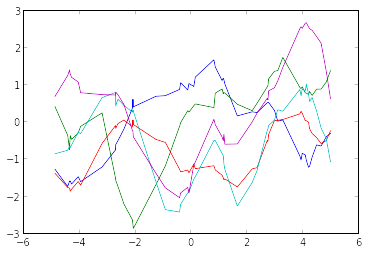

In [3]:
# sample data from the prior
X = np.asarray(sorted(np.random.rand(50)*10-5)).reshape((-1,1))

#cov = GPCov(wfn_params=[1.0], dfn_params=[0.5,], dfn_str="euclidean", wfn_str="se")
noise_var = 0.01
true_theta = [1.0, 0.5]
KK = cov_matrix(X, X, true_theta) + np.eye(X.shape[0])*noise_var

y = scipy.stats.multivariate_normal(mean=np.zeros((X.shape[0],)), cov=KK).rvs(5)
YY = np.dot(y.T, y)
#y = np.array([prior_sample(X, cov, noise_var) for i in range(5)])

for i in range(y.shape[0]):
    plot(X, y[i,:])


In [4]:
def vec(scalar):
    return np.array((scalar,), dtype=np.float)

cov = GPCov(wfn_params=[1.0], dfn_params=[0.5,], dfn_str="euclidean", wfn_str="se")
centers = [vec(-4), vec(-2), vec(0), vec(2), vec(4)]
#centers = [vec(-2), vec(2)]
n_blocks = len(centers)
block_covs = []
lgps = LocalGPs(block_centers=centers, cov_block_params = [(noise_var, 1.0, 0.5)]*n_blocks, X=X, y=y[0,:])

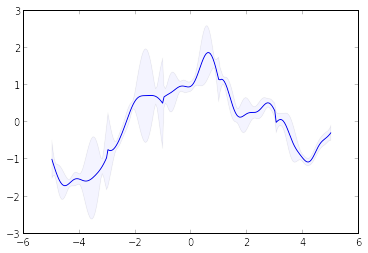

In [5]:
xpred = np.linspace(-5, 5, 200).reshape((-1, 1))
ypred = lgps.predict(xpred)
stds = np.sqrt(np.diag(lgps.covariance(xpred)))
plot_std(xpred, ypred, stds)


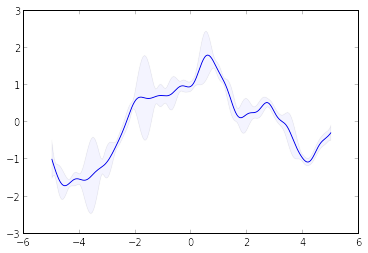

In [6]:
gp = GP(X=X, y=y[0,:], noise_var=noise_var, cov_main=cov, compute_ll=True, sort_events=False, compute_grad=True)
ypred = gp.predict(xpred)
stds = np.sqrt(gp.variance(xpred))
plot_std(xpred, ypred, stds)


In [7]:


bcm = BCM(test_cov=cov, block_centers=centers, cov_block_params = [(noise_var, 1.0, 0.5)]*n_blocks, X=X, y=y[0,:])

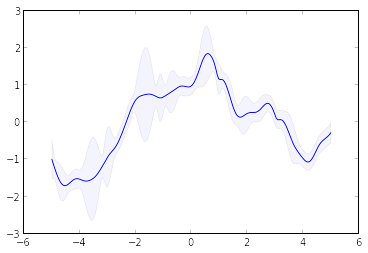

In [8]:
means, vs = bcm.predict_dist(xpred, diag=True)
stds = np.sqrt(vs)    
plot_std(xpred, np.array(means), stds)

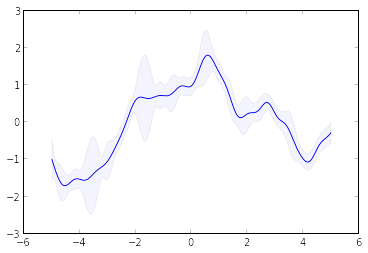

In [9]:
m, c = bcm.predict_dist(xpred, noise_var=0.01)
stds = np.sqrt(np.diag(c))    
plot_std(xpred, np.array(m), stds)

In [10]:
print gp.log_likelihood()
print lgps.likelihood()
print bcm.likelihood()

-9.2702637561
-12.0544564979
block 1 conditional ll -1.07 vs prior -1.59
block 2 conditional ll -3.95 vs prior -4.41
block 3 conditional ll 1.12 vs prior 0.08
block 4 conditional ll -1.85 vs prior -2.62
-9.26454817559


In [11]:
print lgps.likelihood_grad()
print gp.ll_grad

[ -58.97433422    0.46862251   10.08503802   32.36167077   -1.44104576
    5.067398     67.02932865   -0.38962915    8.84877174 -189.85063969
   -2.23441054    7.7442764   241.96568241   -2.40932856    6.28798082]
[ 133.106463     -5.97737387   40.69530101]


  status: 0
 success: True
    nfev: 35
     fun: -6.0609856813673559
       x: array([ 0.01186944,  0.71267546,  1.04861135])
 message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     jac: array([  7.56535867e-05,  -5.83017734e-07,   5.50440834e-07])
     nit: 16


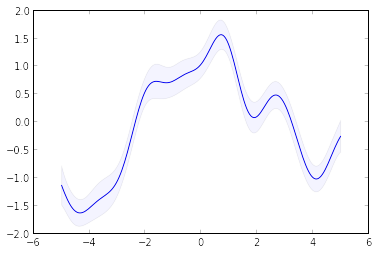

In [20]:
# optimize GP params:
def buildgp(params):
    noise_var = params[0]
    cov = GPCov(wfn_params=params[1:2], dfn_params=params[2:], dfn_str="euclidean", wfn_str="se")
    gp = GP(X=X, y=y[0,:], noise_var=noise_var, cov_main=cov, compute_ll=True, sort_events=False, compute_grad=True)
    return gp

def gp_llgrad(params):
    gp = buildgp(params)
    return -gp.ll, -gp.ll_grad

x0 = np.random.rand(3)
bounds = [(0.001, None), (0.001, None), (0.001, None)]
r = scipy.optimize.minimize(gp_llgrad, x0, jac=True, bounds=bounds)
print r

gp = buildgp(r.x)
ypred = gp.predict(xpred)
stds = np.sqrt(gp.variance(xpred, include_obs=True))
plot_std(xpred, ypred, stds)


  status: 0
 success: True
    nfev: 18
     fun: 0.82941553770175247
       x: array([ 0.01159942,  0.74386271,  1.00873896])
 message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     jac: array([ -1.95004714e-06,   6.87995454e-07,  -4.02416686e-07])
     nit: 12


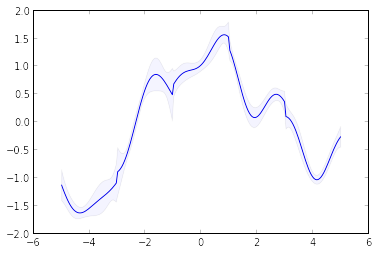

In [13]:
# optimize LGP params:
def build_lgp(params):
    lgps = LocalGPs(block_centers=centers, cov_block_params = [params], X=X, y=y[0,:])
    return lgps

def lgp_llgrad(params):
    lgps = build_lgp(params)
    ll = lgps.likelihood()
    llgrad = lgps.likelihood_grad()
    return -ll, -llgrad

x0 = np.random.rand(3)
bounds = [(0.001, None), (0.001, None), (0.001, None)]
r = scipy.optimize.minimize(lgp_llgrad, x0, jac=True, bounds=bounds)
print r

lgps = build_lgp(r.x)
ypred = lgps.predict(xpred)
stds = np.sqrt(np.diag(lgps.covariance(xpred)))
plot_std(xpred, ypred, stds)


  status: 0
 success: True
    nfev: 26
     fun: -6.1401772953157341
       x: array([ 0.01187701,  0.73398383,  1.06505343])
 message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     jac: array([  3.37133305e-03,   3.91573570e-06,  -6.75220467e-05])
     nit: 16


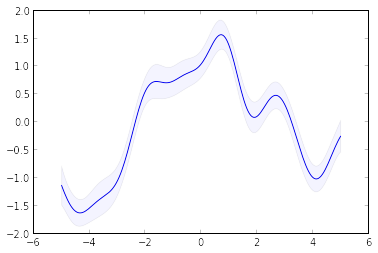

In [14]:
# optimize BCM params:
def build_bcm(params):
    ccov = GPCov(wfn_params=params[1:2], dfn_params=params[2:], dfn_str="euclidean", wfn_str="se")
    bcm = BCM(test_cov=ccov, block_centers=centers, cov_block_params = [params], X=X, y=y[0,:])
    return bcm

def bcm_llgrad(params):
    bcm = build_bcm(params)
    ll, llgrad = bcm.llgrad()
    return -ll, -llgrad

x0 = np.random.rand(3)
bounds = [(0.001, None), (0.001, None), (0.001, None)]
r = scipy.optimize.minimize(bcm_llgrad, x0, jac=True, bounds=bounds)
print r

bcm = build_bcm(r.x)
m, c = bcm.predict_dist(xpred, noise_var=r.x[0])
stds = np.sqrt(np.diag(c))    
plot_std(xpred, np.array(m), stds)


In [15]:
# pseudooptimize BCM params:
def bcm_pseudo_llgrad(params):
    bcm = build_bcm(params)
    ll, llgrad = bcm.cycle_pseudoll()
    return -ll, -llgrad

def grad_step(f, x, alpha):
    ll, llgrad = f(x)
    delta = llgrad*alpha
    x += delta
    return x, delta

def grad_ascent(f, x0, thresh=0.1):
    step = 1
    delta = np.ones(x0.shape)
    x = x0
    while np.linalg.norm(delta) > thresh:            
        alpha = 1.0/step
        x, delta = grad_step(f, x, alpha)
        step += 1
        if step % 10 == 0:
            print "step %d delta %.3f" % (step, delta)
    return x
    
x0 = np.random.rand(3)
#rx = grad_ascent(bcm_pseudo_llgrad, x0)

bounds = [(0.001, None), (0.001, None), (0.001, None)]
r = scipy.optimize.minimize(bcm_pseudo_llgrad, x0, jac=True, bounds=bounds)


  status: 0
 success: True
    nfev: 32
     fun: -2.6538415905772363
       x: array([ 0.0118871 ,  0.64715849,  1.07043804])
 message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     jac: array([  3.21226822e-04,   1.02399389e-05,  -7.46321285e-06])
     nit: 16


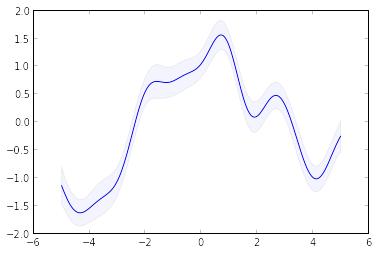

In [19]:
print r
bcm = build_bcm(r.x)
m, c = bcm.predict_dist(xpred, noise_var=r.x[0])
stds = np.sqrt(np.diag(c))    
plot_std(xpred, np.array(m), stds)